# Linear Regression With Two Trainable Weights
If we look at the problem of fitting a line using the line equation $y = ax + b$, we need to provide both the gradient $a$ and the offset $b$. This means we need to train two variables, $a$ and $b$ where $a$ is the gradient and $b$ is the bias.

What I want to do here is use the Tensorflow 2.0 libraries and the Stochastic Gradient Descent (SGD) optimizer to train the values. It also mean we have to start using the GradientTape class as the SGD optimizer uses the gradients to optimize the model.

The basic flow of the code then is:

1. Create a set of training data with a known gradient and offset.
2. Create gradient (a) and offset (b) Tensorflow variables to train to match the gradient / offset
3. Use a GradientTape and SGD optimizer to train the Tensorflow variables and see how close we can get.

Start by importing the libraries we need.

In [403]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

Set the gradient and offset for the training data.

In [404]:
actual_gradient = 5.
actual_offset = 3.

Create some training data and plot it so we can visualise it.

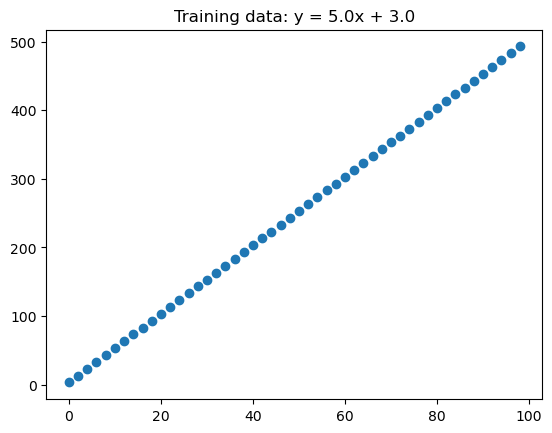

In [405]:
X_train = np.arange(stop=100, step=2, dtype=np.float32)
Y_train = X_train * actual_gradient + actual_offset

plt.scatter(X_train, Y_train)
plt.title(f"Training data: y = {actual_gradient}x + {actual_offset}")
plt.show()

Create the $a$ and $b$ coefficients and initialize them to zero. One interesting experiment is to change them to random numbers and seeing what happens.

In [406]:
a = tf.Variable(0., trainable=True)
b = tf.Variable(0., trainable=True)

Next we create the SGD optimizer and set a learning rate. The learning rate is something you have to experiment with to find a value that works. Usually values between 0.1 and 0.0001 are used. It's also interesting to experimenting with changing the learning rate as the loss decreases. This can allow you to speed up training and get to a more accurate result.

In [407]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)

Create a loss history list so we can plot the loss from the training stage.

In [408]:
loss_history = np.array([])

Now we enter the main training loop. Note I've not created seprate steps or batches here. I've just created a big loop and created an array of losses for all of the y values in the training set.

I start by creating the GradientTape which will track all of the gradients... somehow... by magic.

Inside the scope of the GradientTape, I generate a run of predicted Y values based on the coefficients I'm training (a and b). Once that is done I create an array of losses, one for each Y value using the equation $loss = \hat{y} - y$.

This loss is then used to calculate gradients for a and b wich are then applied by the optimizer to update the values for a and b.

Every ten times around the loop, I get the mean loss and add it to the loss history for plotting later.

In [409]:
for i in range(15000):
    with tf.GradientTape() as tape:
        Y_test = X_train * a + b
        loss = tf.abs(Y_train - Y_test)
        
    gradients = tape.gradient(loss, [a, b])
    opt.apply_gradients(zip(gradients, [a, b]))
    if i % 10 == 0:
        loss_history = np.append(loss_history, np.mean(loss.numpy()))
    
print(f'Final result: y = a: {a.numpy():.04f}, b: {b.numpy():.04f}')

Final result: y = a: 4.9825, b: 2.9952


Finally I plot the loss history and output the coefficients that have been learned. If you run the code yourself you can see that the values get pretty close to the original coefficients.

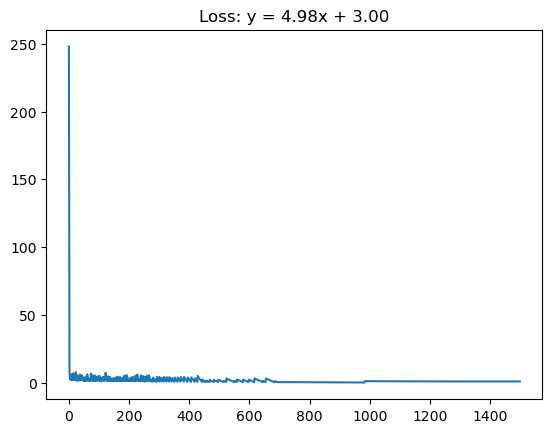

In [410]:
plt.plot(loss_history)
plt.title(f'Loss: y = {a.numpy():.02f}x + {b.numpy():.02f}')
plt.show()

Looking at the Loss curve, it's interesting to see the jagged, sawtooth-like shape of it. When I was first thinking about how this process might work under the hood, before writing the code, I couldn't figure out how the optimizer would be able to figure out that one coefficient is the gradient and the other is a bias. How can it do this when the loss is calculated based on the overall loss, not the individual weights?

Having written this code though, I can see that in using the $y=ax+b$ equation in the loss function I'm forcing the optimizer to do this.

If you think about it, the loss decreases in one of two scenarios:
1. The bias gets closer to the target bias
2. The gradient gets closer to the target gradient.

So both coefficients start out at zero and there is big loss in the first iteration. This is going to create big changes to both coefficients and 'move the line' towards the overall mean of the curve with probably a fairly large gradient too. After that though perhaps we're seeing a training process that is doing something along the lines of: 
- Shuffles up while the error is decreasing but then it'll start to go up again
- Gradient changes to decrease loss until the gradient is roughly right
- But bias is now causing the error so that adjusts until the error starts to go up again
- Then we're back to adjusting gradient again.

Perhaps this is why we see this 'sawtooth' type pattern in the loss history.

### Areas for future study
1. I still don't think I really understand the Gradient Tape process and what it's doing.
2. I don''t understand why I had to use `loss = tf.abs(Y_train - Y_test)` and not mean squared error
3. I don't understand why I had to use `apply_gradients()` rather than `minimize()`